In [48]:
%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Import Data

In [2]:
dfList = []
for r, d, f in os.walk('../data/dunnhumby - The Complete Journey CSV/'):
    for file in f:
        if '.csv' in file:
            print(file)
            dfList.append(pd.read_csv(os.path.join(r, file)))

campaign_desc.csv
campaign_table.csv
causal_data.csv
coupon.csv
coupon_redempt.csv
hh_demographic.csv
product.csv
transaction_data.csv


In [3]:
campaign_desc_df = dfList[0]
campaign_table_df = dfList[1]
causal_data_df = dfList[2]
coupon_df = dfList[3]
coupon_redempt_df = dfList[4]
hh_demographic_df = dfList[5]
product_df = dfList[6]
transaction_data_df = dfList[7]

# Observing Data

In [ ]:
campaign_desc_df.head(2)

In [ ]:
campaign_table_df.head(2)

In [ ]:
causal_data_df.head(2)

In [ ]:
coupon_df.head(2)

In [ ]:
coupon_redempt_df.head(2)

In [22]:
hh_demographic_df.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,purchase_rate
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,6.610931
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,4.956341


This seems to be interesting data about households

## Product Data

In [ ]:
product_df.head(10)

In [ ]:
product_df.groupby('DEPARTMENT')['PRODUCT_ID'].count().plot.bar(rot=90,figsize=(9,5))

Let us look at what kind of grocery items we can find

In [ ]:
product_df[product_df['DEPARTMENT']=='GROCERY'].groupby('COMMODITY_DESC')['PRODUCT_ID'].count().sort_values(ascending=False)

Let us look at what kind of 'Drug GM' products we have

In [ ]:
product_df[product_df['DEPARTMENT']=='DRUG GM'].groupby('COMMODITY_DESC')['PRODUCT_ID'].count().sort_values(ascending=False)

## Transaction Data

In [ ]:
transaction_data_df.head()

# Question 1: How is purchasing rate related to income?

If we want to compare shopping amounts amongst households, we are subject to transaction amounts and the time in which they took place. We can compare the shopping rate amongst households by taking the derivative of the sales value over the cumulative days in which the shopping occured 

In [4]:
# turn the days of purchase into a list
days_purchased_each_house=transaction_data_df.groupby(['household_key','DAY','STORE_ID'])['SALES_VALUE']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['DAY'].apply(list)
days_purchased_each_house.head()


household_key
1    [51, 67, 88, 94, 101, 108, 111, 128, 137, 146,...
2    [103, 112, 117, 118, 121, 139, 140, 147, 154, ...
3    [113, 121, 136, 139, 141, 142, 163, 166, 169, ...
4    [104, 140, 154, 181, 190, 199, 216, 231, 244, ...
5    [85, 87, 88, 97, 111, 131, 138, 154, 168, 181,...
Name: DAY, dtype: object

In [5]:
#turn the transaction values into a list
transaction_val_each_house=transaction_data_df.groupby(['household_key','DAY','STORE_ID'])['SALES_VALUE']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['SALES_VALUE'].apply(list)
transaction_val_each_house.head()

household_key
1    [78.66, 41.1, 26.9, 63.43, 53.449999999999996,...
2    [22.7, 4.38, 12.84, 30.849999999999994, 26.94,...
3    [46.81000000000001, 21.450000000000003, 74.43,...
4    [126.23999999999997, 123.77999999999999, 31.75...
5    [4.48, 5.54, 13.68, 60.04000000000001, 58.4899...
Name: SALES_VALUE, dtype: object

In [6]:
#merge
transaction_freq_df = pd.merge(transaction_val_each_house,days_purchased_each_house,\
                               left_on='household_key',right_on='household_key')


In [7]:
transaction_freq_df.head()
    

,SALES_VALUE,DAY
household_key,,
1,"[78.66, 41.1, 26.9, 63.43, 53.449999999999996,...","[51, 67, 88, 94, 101, 108, 111, 128, 137, 146,..."
2,"[22.7, 4.38, 12.84, 30.849999999999994, 26.94,...","[103, 112, 117, 118, 121, 139, 140, 147, 154, ..."
3,"[46.81000000000001, 21.450000000000003, 74.43,...","[113, 121, 136, 139, 141, 142, 163, 166, 169, ..."
4,"[126.23999999999997, 123.77999999999999, 31.75...","[104, 140, 154, 181, 190, 199, 216, 231, 244, ..."
5,"[4.48, 5.54, 13.68, 60.04000000000001, 58.4899...","[85, 87, 88, 97, 111, 131, 138, 154, 168, 181,..."


In [13]:
def compute_transaction_rate(df):
    x = np.array(df['DAY'])
    #Compute cumulative sum of sales value
    y = []
    cum_trans = 0
    for transaction in df['SALES_VALUE']:
        cum_trans = cum_trans+transaction
    if (x[-1]-x[0])==0:
        ans = np.nan
    else:
        ans = cum_trans/(x[-1]-x[0])
    return ans

Text(0, 0.5, 'Frequency')

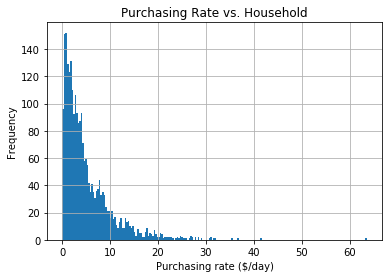

In [29]:
purchase_rate=transaction_freq_df.apply(compute_transaction_rate,axis=1)
purchase_rate.hist(bins=200)
ax = plt.gca()
ax.set_title('Purchasing Rate vs. Household')
ax.set_xlabel('Purchasing rate ($/day)')
ax.set_ylabel('Frequency')


In [31]:
purchase_rate.sort_values(ascending=False)
#Find outliers

household_key
1023    63.548574
1609    41.643767
2322    36.661891
1453    35.336525
1430    32.051953
          ...    
1647     0.081174
522      0.070870
494           NaN
1830          NaN
1897          NaN
Length: 2500, dtype: float64

In [15]:
purchase_rate.rename('purchase_rate',inplace=True)
hh_demographic_df = hh_demographic_df.join(purchase_rate,on='household_key')

In [21]:
hh_demographic_df.replace('5+','6').\
groupby('HOUSEHOLD_SIZE_DESC')['purchase_rate'].agg(['mean','std'])
#ax = plt.gca()
#ax.set_title('Purchasing Rate vs. Household Size')
#ax.set_xlabel('Household')
#ax.set_ylabel('Purchasing rate ($/day)')

,mean,std
HOUSEHOLD_SIZE_DESC,,
1,7.817810,5.130117
2,8.743405,5.416140
3,9.566740,6.791548
4,10.382001,6.231943
6,10.325423,7.857083


In [63]:
idesc_purchrate = hh_demographic_df.groupby(['INCOME_DESC','purchase_rate'])['household_key'].count().\
reset_index().drop(columns='household_key').sort_values(by='purchase_rate',ascending=False)
idesc_purchrate.head()

,INCOME_DESC,purchase_rate
71,125-149K,41.643767
186,175-199K,36.661891
70,125-149K,35.336525
451,35-49K,32.051953
33,100-124K,31.569770


Text(0, 0.5, 'Purchase Rate ($/day)')

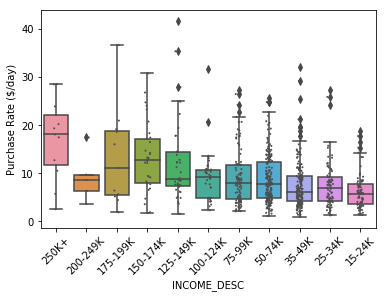

In [91]:
order = ['250K+','200-249K','175-199K','150-174K','125-149K','100-124K', '75-99K','50-74K','35-49K','25-34K','15-24K']
p1=sns.stripplot(x=idesc_purchrate.INCOME_DESC, y=idesc_purchrate.purchase_rate, data=idesc_purchrate,order=order,size=2,color='.3')
p1.set_xticklabels(p1.get_xticklabels(),rotation=45)
p1 = sns.boxplot(x=idesc_purchrate.INCOME_DESC, y=idesc_purchrate.purchase_rate, data=idesc_purchrate,order=order)
p1.set_ylabel('Purchase Rate ($/day)')

In [27]:
hh_demographic_df.groupby('AGE_DESC')['purchase_rate'].agg(['mean','std']).sort_values(by='mean',ascending=False)

,mean,std
AGE_DESC,,
35-44,9.986070,6.403561
45-54,9.036293,6.286432
25-34,8.548801,5.415285
55-64,7.928738,4.800478
19-24,7.411020,4.467614
65+,6.750850,4.171274
